In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Data 255 Spring 2024/Google Colab/Homework10'

/content/drive/My Drive/Data 255 Spring 2024/Google Colab/Homework10


In [ ]:
pwd

'/content/drive/My Drive/Data 255 Spring 2024/Google Colab/Homework10'

Follow the demo and run the demo notebook on your local machine.
BERT for QnA:
1. Load the SQUAD 2.0 (https://pytorch.org/text/stable/datasets.html#torchtext.datasets.SQuAD2
Links to an external site.
) dataset from pytorch dataset library. take minimum 20 QnA pairs.
2. Display a few raw QnA data samples.
3. Preprocess/Clean dataset as per BERT format.
4. Train the BERT QnA model. Evaluate the model.
5. Perform an Inference and show the predicted vs ground truth answers.


In [ ]:
#%%capture - not show output
#!pip install transformers

## 1. Load the SQUAD 2.0 (https://pytorch.org/text/stable/datasets.html#torchtext.datasets.SQuAD2 Links to an external site. ) dataset from pytorch dataset library. take minimum 20 QnA pairs. (I have done for 100 questions. The QA pair has the passage, question and answer.)

In [ ]:
%%capture
# Load necessary libraries
import json
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import DataLoader, TensorDataset
# Load BERT for QA
from transformers import BertTokenizer, BertForQuestionAnswering
import time
import re
import csv

In [ ]:
# Check if we are using CPU or GPU
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
#%%capture
# Download the necessary datasets
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

mkdir: cannot create directory ‘squad’: File exists
--2024-04-20 21:40:16--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘squad/train-v2.0.json’

squad/train-v2.0.js 100%[===================>]  40.17M  77.2MB/s    in 0.5s    

2024-04-20 21:40:17 (77.2 MB/s) - ‘squad/train-v2.0.json’ saved [42123633/42123633]

--2024-04-20 21:40:17--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [ap

In [ ]:
# Data cleaning tasks
def clean_text(text):
    # Example cleaning task: removing non-alphanumeric characters
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return cleaned_text

In [ ]:
# Define the path to the SQuAD 2.0 training data
path = "squad/train-v2.0.json"

# Load and preprocess the SQuAD 2.0 data
def load_squad_data(path, limit=100):
    with open(path, 'r') as f:
        squad_dict = json.load(f)

    texts = []
    questions = []
    answers = []
    count = 0
    for group in squad_dict['data']:
        if count >= limit:
            break
        for passage in group['paragraphs']:
            if count >= limit:
                break
            context = (passage['context'])  # Clean the context
            for qa in passage['qas']:
                if count >= limit:
                    break
                question = (qa['question'])  # Clean the question
                if qa['is_impossible']:
                    texts.append(context)
                    questions.append(question)
                    answers.append({'text': '', 'answer_start': -1})
                    count += 1
                else:
                    for answer in qa['answers']:
                        texts.append(context)
                        questions.append(question)
                        answers.append(answer)
                        count += 1
                        if count >= limit:
                            break

    return texts, questions, answers

# Function to convert loaded data to CSV
def data_to_csv(texts, questions, answers, csv_path):
    with open(csv_path, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Context", "Question", "Answer Text", "Answer Start Position"])

        for text, question, answer in zip(texts, questions, answers):
            writer.writerow([text, question, answer['text'], answer['answer_start']])


# Load and preprocess the data to find answer start and end positions
train_texts, train_queries, train_answers = load_squad_data(path)

In [ ]:
# Define the path to the SQuAD 2.0 val/testing data
path = "squad/dev-v2.0.json"

# Load and preprocess the SQuAD 2.0 data
def load_squad_data(path, limit=20):
    with open(path, 'r') as f:
        squad_dict = json.load(f)

    texts = []
    questions = []
    answers = []
    count = 0
    for group in squad_dict['data']:
        if count >= limit:
            break
        for passage in group['paragraphs']:
            if count >= limit:
                break
            context = (passage['context'])  # Clean the context
            for qa in passage['qas']:
                if count >= limit:
                    break
                question = (qa['question'])  # Clean the question
                if qa['is_impossible']:
                    texts.append(context)
                    questions.append(question)
                    answers.append({'text': '', 'answer_start': -1})
                    count += 1
                else:
                    for answer in qa['answers']:
                        texts.append(context)
                        questions.append(question)
                        answers.append(answer)
                        count += 1
                        if count >= limit:
                            break

    return texts, questions, answers
# Preprocess the data to find answer start and end positions
val_texts, val_queries, val_answers = load_squad_data(path)

## 2. Display a few raw QnA data samples (5 questions).

In [ ]:
# Display first 5 records from train set
for i in range(5):
    print(f"Context {i+1}: {train_texts[i]}")
    print(f"Question {i+1}: {train_queries[i]}")
    print(f"Answer {i+1}: {train_answers[i]}")
    print("------")

Context 1: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Question 1: When did Beyonce start becoming popular?
Answer 1: {'text': 'in the late 1990s', 'answer_start': 269}
------
Context 2: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised

In [ ]:
# Number of questions downloaded
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

100
100
100


In [ ]:
# Show the first passage, query and answer
print("Passage: ",train_texts[0])
print("Query: ",train_queries[0])
print("Answer: ",train_answers[0])

Passage:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Query:  When did Beyonce start becoming popular?
Answer:  {'text': 'in the late 1990s', 'answer_start': 269}


In [ ]:
print("Passage: ",val_texts[0])
print("Query: ",val_queries[0])
print("Answer: ",val_answers[0])

Passage:  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Query:  In what country is Normandy located?
Answer:  {'text': 'France', 'answer_start': 159}


## 3. Preprocess/Clean dataset as per BERT format.

In [ ]:
# Find the start and end position of the character for train and val

In [ ]:
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2

In [ ]:
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2

In [ ]:
# Tokenize passages and queries
# Tokenization is the process of breaking down the text into smaller
# units such as words or subwords which are later converted into numerical
# representation that is fed into the model for processing

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Tokenize the data
train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

In [ ]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []

    count = 0

    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length

        # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
        if end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)

            # if end position is still None the answer passage has been truncated
            if end_positions[-1] is None:
                count += 1
                end_positions[-1] = tokenizer.model_max_length
    print(count)

    # Update the data in dictionary
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [ ]:
# Create dataset class
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
#  training loops to manage data input for model training and validation efficiently.
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [ ]:
# training loop to iterate over the datasets in manageable chunks,
# making it easier to process large datasets that might not fit entirely into memory.
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
# Build BERT model
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# AdamW which implements gradient bias correction as well as weight decay

from transformers import AdamW
optim = AdamW(model.parameters(), lr=5e-5)

epochs = 50

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 4.Train the BERT QnA model. Evaluate the model. Ran for 50 epochs with dataset having 100 questions and answers.

In [ ]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 1000

for epoch in range(epochs):
    epoch_time = time.time()

    # Set model in train mode
    model.train()
    loss_of_epoch = 0

    print("############Train############")

    for batch_idx,batch in enumerate(train_loader):
        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        # do a backwards pass
        loss.backward()
        # update the weights
        optim.step()
        # Find the total loss
        loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(train_loader)
    train_losses.append(loss_of_epoch)

    ##########Evaluation##################

    # Set model in evaluation mode
    model.eval()

    print("############Evaluate############")

    loss_of_epoch = 0

    for batch_idx,batch in enumerate(val_loader):

        with torch.no_grad():

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            # Find the total loss
            loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(val_loader)
    val_losses.append(loss_of_epoch)

    # Print each epoch's time and train/val loss

    print("\n-------Epoch ", epoch+1,
          "-------"
          "\nTraining Loss:", train_losses[-1],
          "\nValidation Loss:", val_losses[-1],
          "\nTime: ",(time.time() - epoch_time),
          "\n-----------------------",
          "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
############Evaluate############

-------Epoch  1 -------
Training Loss: 4.879585781097412 
Validation Loss: 4.0987015008926395 
Time:  10.052392721176147 
----------------------- 


############Train############
############Evaluate############

-------Epoch  2 -------
Training Loss: 3.5532127904891966 
Validation Loss: 4.036299777030945 
Time:  8.359545707702637 
----------------------- 


############Train############
############Evaluate############

-------Epoch  3 -------
Training Loss: 3.1785050892829894 
Validation Loss: 3.910847043991089 
Time:  7.649577856063843 
----------------------- 


############Train############
############Evaluate############

-------Epoch  4 -------
Training Loss: 2.950534520149231 
Validation Loss: 3.87090163230896 
Time:  7.753751993179321 
----------------------- 


############Train############
############Evaluate############

-------Epoch  5 -------
Training Loss: 2.744128935337067 
Validation Loss: 3.887166666984

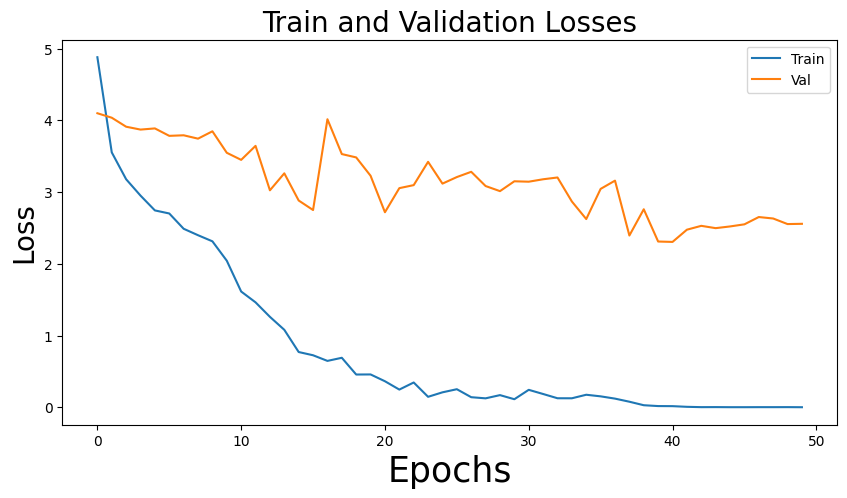

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20)
ax.set_xlabel('Epochs', fontsize = 25)
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

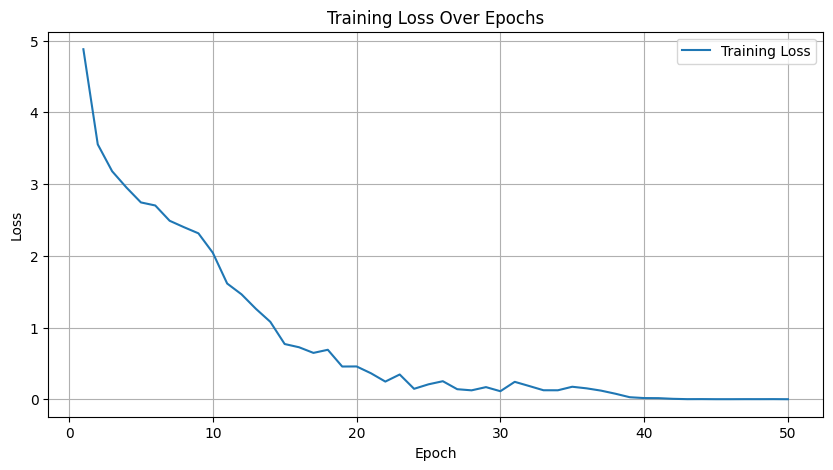

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

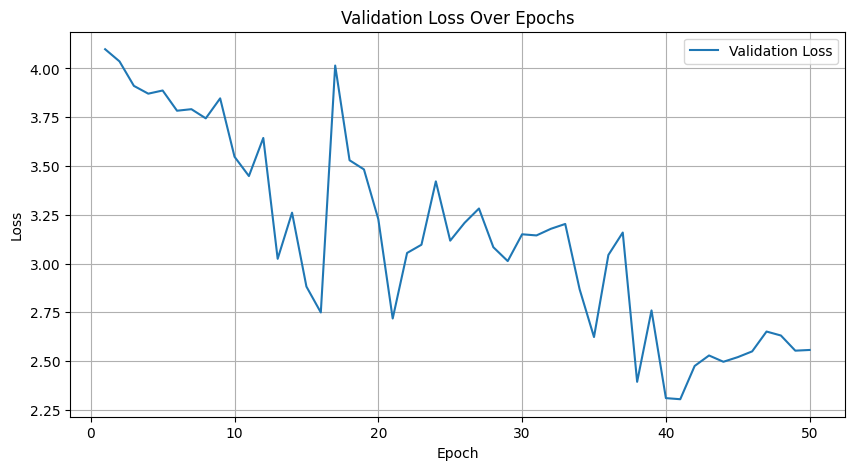

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Show the plots
plt.show()

In [ ]:
# Save model to Google Drive
torch.save(model, 'bert_finetunedmodel_1427')

In [ ]:
bert_model2 = torch.load('bert_finetunedmodel_1427',map_location=torch.device('cpu'))
bert_model2.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

## 5. Perform an Inference and show the predicted vs ground truth answers.

In [ ]:
def predict(context,query):

    inputs = tokenizer.encode_plus(query, context, return_tensors='pt')
    outputs = bert_model2(**inputs)
    answer_start = torch.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(outputs[1]) + 1
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    return answer

def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)

    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    return 2 * (prec * rec) / (prec + rec)

In [ ]:
def give_an_answer(context,query,answer):
    prediction = predict(context,query)
    em_score = compute_exact_match(prediction, answer)
    f1_score = compute_f1(prediction, answer)
    print(f"Question: {query}")
    print(f"Prediction: {prediction}")
    print(f"True Answer: {answer}")
    #print(f"EM: {em_score}")
    #print(f"F1: {f1_score}")
    print("\n")

## Inference 1

In [ ]:
# Example usage:
context = "Beyoncé rose to fame in the late 1990s as the lead singer of Destiny's Child."
query = "When did Beyonce start becoming popular?"
answer = "in the late 1990s"
give_an_answer(context, query, answer)

Question: When did Beyonce start becoming popular?
Prediction: in the late 1990s
True Answer: in the late 1990s




## Inference 2

In [ ]:
context = " Hi! I live in San Jose for past 6 years!. I used to work in San Jose. San Jose is located in California, USA. "

queries = ["How long have I lived in San Jose?",
           "Where did you work?"
          ]
answers = ["6 years",
           "San Jose"
          ]

for q,a in zip(queries,answers):
    give_an_answer(context,q,a)


Question: How long have I lived in San Jose?
Prediction: 6 years!. i used to work in san jose.
True Answer: 6 years


Question: Where did you work?
Prediction: san jose.
True Answer: San Jose




In [ ]:
context = " Hi! I live in San Jose for past 6 years and working in San Jose and I love it here."

queries = ["How long have I lived in San Jose?",
           "Where did you work?"
          ]
answers = ["6 years",
           "San Jose"
          ]

for q,a in zip(queries,answers):
    give_an_answer(context,q,a)

Question: How long have I lived in San Jose?
Prediction: 6 years and working in san jose and i love it here. [SEP]
True Answer: 6 years


Question: Where did you work?
Prediction: san jose for past 6 years and working in san jose and i love it here. [SEP]
True Answer: San Jose


